<a href="https://colab.research.google.com/github/Jiaweihu08/Real-or-Not---Text-Classification/blob/master/Real_or_Not_Tweeter_Disaster_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import FreqDist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re
import string

TensorFlow 2.x selected.


Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_path = "/content/drive/My Drive/Colab Notebooks/NLP/Real or Not/train.csv"
test_path = "/content/drive/My Drive/Colab Notebooks/NLP/Real or Not/test.csv"

def load_data(path=train_path):
    return pd.read_csv(path)

df = load_data()
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### EDA

1. General Dataset info

    a. Number of samples

    b. Data columns

    c. Class label distribution

2. Text Analysis
    
    a. Number of characters in tweets

    b. Number of words in tweets

    c. Average word length in tweets

    d. Common word distribution

    e. Hashtag analysis

    f. KW and Location analysis

#### General Dataset Information

In [0]:
print("- Number of total training instances: {}".format(len(df)))
print("- Columns in the training dataset: \n    {}".format(df.columns))

- Number of total training instances: 7613
- Columns in the training dataset: 
    Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


- Total number of positive instances: 3271
- Total number of negative instances: 4342


Text(0, 0.5, 'samples')

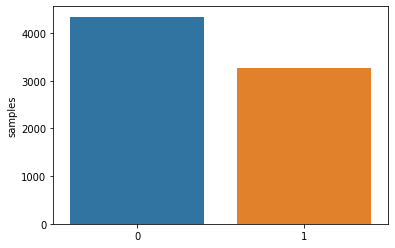

In [0]:
print("- Total number of positive instances: {}".format(len(df.loc[df['target'] == 1])))
print("- Total number of negative instances: {}".format(len(df.loc[df['target'] == 0])))

x = df.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

#### Text Analysis

##### **a/b. Character and Word Distribution:**

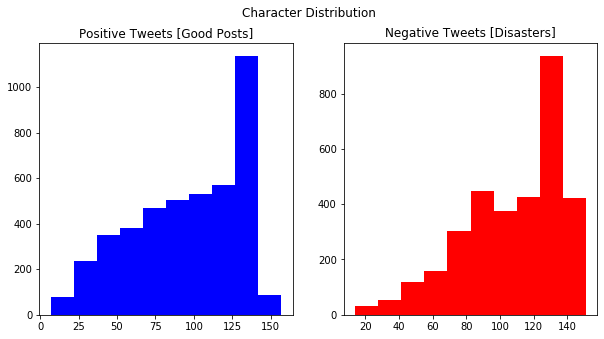

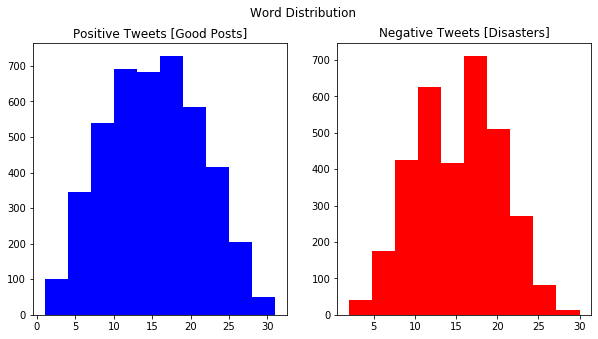

In [0]:
def plot_hist(dist, _header):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
    #sns.distplot(dist(0), ax=ax1, color='blue')
    ax1.hist(dist(0), color='blue')
    ax1.set_title("Positive Tweets [Good Posts]")
    
    #sns.distplot(dist(1), ax=ax2, color='red')
    ax2.hist(dist(1), color='red')
    ax2.set_title("Negative Tweets [Disasters]")
    fig.suptitle(_header)
    plt.show()
    plt.close()

def char_length(_target):
    return df[df['target'] == _target]['text'].str.len()

def num_words(_target):
    return df[df['target'] == _target]['text'].str.split().map(lambda x: len(x))

plot_hist(char_length, "Character Distribution")

plot_hist(num_words, "Word Distribution")

##### **c. Average Word Length Distribution:**

Difference between map, apply, and applymap:
1. map does element-wise operations on a Series
2. apply does operations on a columns/row bases of a DataFrame
3. applymap works element-wise on a DataFrame

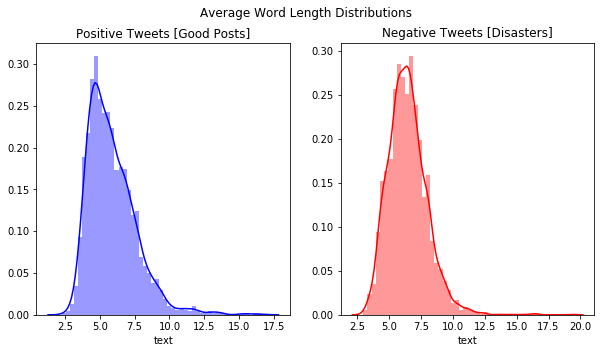

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

p_avg_len = df[df['target'] == 0]['text'].str.split().map(lambda x: [len(i) for i in x])
sns.distplot(p_avg_len.map(lambda x: np.mean(x)), ax=ax1, color='blue')
#ax1.hist(p_avg_len.map(lambda x: np.mean(x)), color='blue')
ax1.set_title('Positive Tweets [Good Posts]')

n_avg_len = df[df['target'] == 1]['text'].str.split().map(lambda x: [len(i) for i in x])
sns.distplot(n_avg_len.map(lambda x: np.mean(x)), ax=ax2, color='red')
#ax2.hist(n_avg_len.map(lambda x: np.mean(x)), color='red')
ax2.set_title('Negative Tweets [Disasters]')

fig.suptitle('Average Word Length Distributions')
plt.show()
plt.close()

##### **d. Most Common Word distribution:**

In [0]:
stop = set(stopwords.words('english') + ['http', 'https', 'nt'])

def show_word_distribution(target=1, field='text', stop=stop):
    b = 'disaster' if target == 1 else 'good'
    print("Most common words in {} tweets".format(b))
    
    txt = df[df['target'] == target][field].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
    words = word_tokenize(txt)
    not_stop_word_dist = FreqDist(w for w in words if w not in stop)
    
    # vocab = Counter()
    # txt = df[df['target'] == target]['text'].str.lower().str.replace(r'\|', ' ')
    # for text in txt:
    #     not_stop_words = [w for w in word_tokenize(text) if w not in stop]
    #     vocab.update(not_stop_words)
    
    result = pd.DataFrame(not_stop_word_dist.most_common(10), columns = ['Word', 'Frequency']).set_index('Word')
    print(result)
    result.plot.bar(rot=0)

Most common words in good tweets
      Frequency
Word           
:          3030
?          2364
.          1882
@          1854
#          1700
!           843
's          515
...         426
'           400
-           388
Most common words in disaster tweets
      Frequency
Word           
:          3676
#          1703
.          1085
@           905
?           762
...         637
-           397
!           330
'           295
's          276


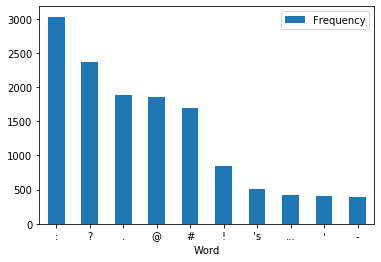

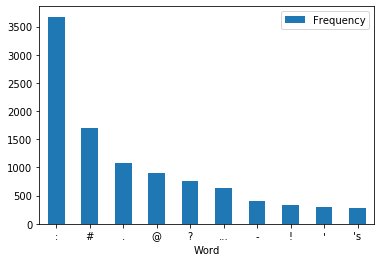

In [0]:
show_word_distribution(0)
show_word_distribution(1)

##### **e. Hashtag Analysis**

In [0]:
def find_hashtags(tweet):
    return ", ".join(re.findall(r'#\w+', tweet)) or None

def add_hashtags(df):
    df['hashtags'] = df['text'].map(lambda tweet: find_hashtags(tweet))
    #df['hashtags'].fillna(value='no', inplace=True)
    return df

In [0]:
df = add_hashtags(df)
df[['hashtags']].head(10)

,hashtags
0,#earthquake
1,None
2,None
3,#wildfires
4,"#Alaska, #wildfires"
5,"#RockyFire, #CAfire, #wildfires"
6,"#flood, #disaster"
7,None
8,None
9,None


In [0]:
tweets_w_hash = len([tag for tag in df.hashtags.values if isinstance(tag, str)])
print("Number of tweets with hashtags: {}, {:.2f}%".format(tweets_w_hash,
                                                           tweets_w_hash/len(df)*100))

Number of tweets with hashtags: 1743, 22.90%


Most common words in good tweets
            Frequency
Word                 
nowplaying         21
news               20
hot                18
prebreak           17
best               17
gbbo               14
jobs               14
islam              14
job                12
hiring             10
Most common words in disaster tweets
            Frequency
Word                 
news               56
hiroshima          22
earthquake         19
hot                13
prebreak           13
best               13
japan              11
india              10
yyc                10
breaking            9


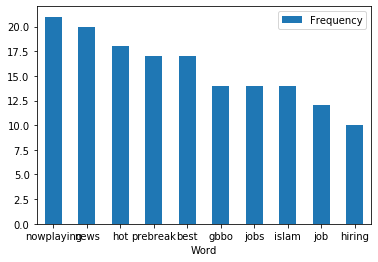

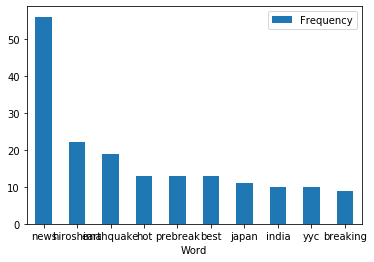

In [0]:
stop_1 = set(list(stop)+['#', ','])
show_word_distribution(0, 'hashtags', stop_1)
show_word_distribution(1, 'hashtags', stop_1)

##### **f. KW and Location Analysis**

In [0]:
df.head()

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,#earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,None
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,None
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,#wildfires
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"#Alaska, #wildfires"


In [0]:
total_kw = len(df) - len(df[df['keyword'].isna()])
unique_kw = len({w for w in df.keyword.values if isinstance(w, str)})

print('There are {} unique keywords out of {} in total.'.format(unique_kw, total_kw))
print('There are {} instances with no keyword'.format(len(df[df['keyword'].isna()])))

num_un_loc = len({lc for lc in df.location.values if isinstance(lc, str)})
num_no_loc = len(df[df['location'].isna()])
num_rows = len(df)
print("\nThere are {} rows in total, {} of them have no locations.\n\
There are {} unique locations\nLocation is too sparse to be used.".format(num_rows,
                                                                          num_no_loc,
                                                                          num_un_loc))

There are 221 unique keywords out of 7552 in total.
There are 61 instances with no keyword

There are 7613 rows in total, 2533 of them have no locations.
There are 3341 unique locations
Location is too sparse to be used.


In [0]:
df['keyword'] = df['keyword'].map(lambda s: s.replace('%20', " ") if isinstance(s, str) else s)

In [0]:
positive_kw_count = dict(df[df['target'] == 0].keyword.value_counts())
negative_kw_count = dict(df[df['target'] == 1].keyword.value_counts())
all_kw_count = dict(df.keyword.value_counts())

In [0]:
for kw, _ in sorted(all_kw_count.items(), key=lambda x: x[1], reverse=True)[:10]:
    print("- Keyword: {}".format(kw))
    print("     -> in positive tweets: {}".format(positive_kw_count.get(kw, None)))
    print("     -> in negative tweets: {}\n".format(negative_kw_count.get(kw, None)))

- Keyword: fatalities
     -> in positive tweets: 19
     -> in negative tweets: 26

- Keyword: armageddon
     -> in positive tweets: 37
     -> in negative tweets: 5

- Keyword: deluge
     -> in positive tweets: 36
     -> in negative tweets: 6

- Keyword: sinking
     -> in positive tweets: 33
     -> in negative tweets: 8

- Keyword: body bags
     -> in positive tweets: 40
     -> in negative tweets: 1

- Keyword: harm
     -> in positive tweets: 37
     -> in negative tweets: 4

- Keyword: damage
     -> in positive tweets: 22
     -> in negative tweets: 19

- Keyword: collided
     -> in positive tweets: 17
     -> in negative tweets: 23

- Keyword: siren
     -> in positive tweets: 35
     -> in negative tweets: 5

- Keyword: twister
     -> in positive tweets: 35
     -> in negative tweets: 5



### Data Cleaning

In [0]:
def clean_data(df, rm_stop=False):

    df['text'] = df['text'].str.lower()
    # Removing url
    def remove_url(tweet):
        pattern = re.compile(r'https?://\S+|www\.\S+')
        return pattern.sub(' ', tweet)

    df['text'] = df['text'].map(lambda tweet: remove_url(tweet))

    # Removing html tags
    def remove_html_tags(tweet):
        pattern = re.compile(r'<.*?>')
        return pattern.sub(' ', tweet)

    df['text'] = df['text'].map(lambda tweet: remove_html_tags(tweet))

    # Removing emojis
    # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    def remove_emoji(tweet):
        emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', tweet)

    df['text'] = df['text'].map(lambda tweet: remove_emoji(tweet))

    # Removing punctuations
    def remove_punct(tweet):
        table = str.maketrans(' ', ' ', string.punctuation)
        return tweet.translate(table)

    df['text'] = df['text'].map(lambda tweet: remove_punct(tweet))

    # Removing stopwords
    def remove_stops(tweet):
        stop = stopwords.words('english')
        return ' '.join([word for word in tweet.split() if word not in stop])
    
    if rm_stop:
        df['text'] = df['text'].map(lambda tweet: remove_stops(tweet))

    return df

# df = clean_data(df)

# show_word_distribution(0)
# show_word_distribution(1)

### Model Testing

1. Baseline Model
2. Gradient Boosting
3. RNN Model
4. Glove LSTM
5. BERT TfHub
6. SuperLearner Ensemble

#### Model Utils

In [0]:
def get_train_val_sets(rm_stop=False):
    df = load_data(train_path)
    #df = add_hashtags(df)
    df = clean_data(df, rm_stop=rm_stop)

    x_train, x_val, y_train, y_val = train_test_split(df.text, df.target,
                                                      test_size=1000, random_state=42)
    
    print("Number of training instances: {}".format(len(x_train)))
    print("Number of validation instances: {}".format(len(x_val)))

    train_set = (x_train, y_train)
    val_set = (x_val, y_val)

    return train_set, val_set

def get_training_data(rm_stop=False):
    df = load_data(train_path)
    #df = add_hashtags(df)
    df = clean_data(df, rm_stop=rm_stop)

    X = df.text.values
    Y = df.target.values

    return X, Y

#### Baseline Model

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

train_set, test_set = get_train_val_sets()
train_X, train_y = train_set
test_X, test_y = test_set

# tfidf_vectorizer = TfidfVectorizer(
#     tokenizer=lambda x: x,
#     preprocessor=lambda x: x,
#     token_pattern=None
# )

base_model_pipe = Pipeline([
                            ('tfidf', TfidfVectorizer()),
                            ('lr', LogisticRegression())
                            ])

base_model_pipe.fit(train_X, train_y)
preds = base_model_pipe.predict(test_X)
print(accuracy_score(test_y, preds))

Number of training instances: 6851
Number of validation instances: 762
0.7847769028871391


#### Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

train_set, test_set = get_train_val_sets()
train_X, train_y = train_set
test_X, test_y = test_set

# tfidf_vectorizer = TfidfVectorizer(
#     tokenizer=lambda x: x,
#     preprocessor=lambda x: x,
#     token_pattern=None
# )

gb_clf = Pipeline([
                   ('tfidf', TfidfVectorizer()),
                   ('gb_clf', GradientBoostingClassifier(n_estimators=300))
])

gb_clf.fit(train_X, train_y)
preds = gb_clf.predict(test_X)
print(accuracy_score(test_y, preds))

Number of training instances: 6851
Number of validation instances: 762
0.7742782152230971


In [0]:
#XGBoost
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xgbclf_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer()),
                        ('xgb_clf', xgboost.XGBClassifier(n_estimators=300))
])

train_set, test_set = get_train_val_sets()
train_X, train_y = train_set
test_X, test_y = test_set

xgbclf_pipe.fit(train_X, train_y)
preds = xgbclf_pipe.predict(test_X)
print(accuracy_score(test_y, preds))

Number of training instances: 6851
Number of validation instances: 762
0.7664041994750657


#### RNN models

##### There are two ways of transforming texts into sequences:
1. Use a lookup table

In [0]:
# First, let's load the data and split them into train and test sets
# using 90% of the data as training set. We're keeping the stopwords
# for now.

def read_data(rm_stop=False):
    df = load_data(train_path)
    df = add_hashtags(df)
    df = clean_data(df, rm_stop)

    train_size = int(len(df)*0.9)

    df_train = df.iloc[:train_size]
    df_val = df.iloc[train_size:]

    print("Data size:")
    print("-- Training: {} rows".format(len(df_train)))
    print("-- Validation: {} rows".format(len(df_val)))

    return df_train, df_val

# Then let's create our vocabularies. We create a lookup table
# with the words in the training set. The oov words in the 
# validation set would be assign to the oov buckets.

def get_lookup_table():
    vocab = Counter()
    for text in df_train.text:
        words = [w for w in word_tokenize(text)]
        vocab.update(words)

    un_words = len(vocab.most_common())
    print(f'\nThere are {un_words} unique words in all the tweets!')

    vocabulary = [word for word, count in vocab.most_common()]
    num_words = len(vocabulary)
    num_oov_buckets = 1300

    vocabulary = tf.constant(vocabulary)
    word_ids = tf.range(num_words, dtype=tf.int64)

    table_init = tf.lookup.KeyValueTensorInitializer(vocabulary, word_ids)
    table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)
    
    return table

# Create the datasets for training

def get_dataset(df):

    texts = tf.strings.split(df.text).to_tensor(default_value=b'<pad>')
    targets = tf.expand_dims(df.target, -1)

    dataset = tf.data.Dataset.from_tensor_slices((texts, targets))
    dataset = dataset.shuffle(1024).batch(32)

    def encode_words(X_batch, Y_batch):
        return table.lookup(X_batch), Y_batch
    
    dataset = dataset.map(lambda X_batch, Y_batch: encode_words(X_batch, Y_batch)).prefetch(1)
    
    return dataset

df_train, df_val = read_data()

table = get_lookup_table()

train_set = get_dataset(df_train)
val_set = get_dataset(df_val)

Data size:
-- Training: 6851 rows
-- Validation: 762 rows
There are 16944 unique words in all the tweets!


In [0]:
def get_rnn_model():

    emb_size = 128
    epochs = 5

    model = keras.models.Sequential([
                                    keras.layers.Embedding(num_words+num_oov_buckets, emb_size, input_shape=[None]),
                                    keras.layers.GRU(128, return_sequences=True),
                                    keras.layers.GRU(128),
                                    keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
model = get_rnn_model()
history = model.fit(train, epochs=epochs, validation_data = val_set, verbose=1)

In [0]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')

plot_graphs(history, 'loss')

Clearly overfitting and performance worse than random guessing(50%).

Let's try excluding the stop words.

In [0]:
df_train, df_val = read_data(rm_stop=True)

table = get_lookup_table()

train_set = get_dataset(df_train)
val_set = get_dataset(df_val)

model = get_rnn_model()
history = model.fit(train, epochs=epochs, validation_data = val_set, verbose=1)

plot_graphs(history, 'accuracy')

plot_graphs(history, 'loss')

Data size:
-- Training: 6851 rows
-- Validation: 762 rows
There are 16816 unique words in all the tweets!
Train for 238 steps, validate for 24 steps
Epoch 1/5
238/238 [==============================] - 23s 97ms/step - loss: 0.6844 - accuracy: 0.5681 - val_loss: 0.6909 - val_accuracy: 0.5341
Epoch 2/5
238/238 [==============================] - 20s 82ms/step - loss: 0.5583 - accuracy: 0.7136 - val_loss: 0.7201 - val_accuracy: 0.5761
Epoch 3/5
238/238 [==============================] - 20s 84ms/step - loss: 0.3172 - accuracy: 0.8797 - val_loss: 0.8869 - val_accuracy: 0.5630
Epoch 4/5
238/238 [==============================] - 20s 83ms/step - loss: 0.1831 - accuracy: 0.9345 - val_loss: 1.1427 - val_accuracy: 0.5617
Epoch 5/5
238/238 [==============================] - 20s 83ms/step - loss: 0.1117 - accuracy: 0.9631 - val_loss: 1.5841 - val_accuracy: 0.5643


Removing stopwords slightly improved the performance of the model though overfitting the training data and it's till not good enough. (0.4672 vs. 0.5643)

##### Next, let's try transforming texts into sequences using
2. Tokenizers

In [0]:
# Before dive into Tokenizing the texts, we need to know how many words
# should be used in that tokenizer and later when padding the sequences,
# we also need to know what should be the length of each sequence.
# Let's take look at what's maximum number of words in all the tweets.

# Here we are converting each tweet into their number of words

df_train, df_val = read_data()
n_words = df_train.text.str.split().map(lambda x: len(x))

print(f"\nThe max number of words in all tweets is {max(n_words)}")
print("Should we set this number as the dimension for our sequences when training?")

Data size:
-- Training: 6851 rows
-- Validation: 762 rows

The max number of words in all tweets is 31
Should we set this number as the dimension for our sequences when training?


In [0]:
# There are about 17,000 unique words in the training set, let's use
# num_words = 10000

num_words = 10000
max_len = 31
batch_size = 32

def get_tokenized_data():
    df_train, df_val = read_data(rm_stop=True)
    
    tokenizer = Tokenizer(num_words = num_words)
    tokenizer.fit_on_texts(df_train.text)

    df = pd.concat([df_train, df_val])

    X = df.text

    le = LabelEncoder()
    Y = le.fit_transform(df.target)
    Y = Y.reshape(-1, 1)

    seq = tokenizer.texts_to_sequences(X)
    seq = pad_sequences(seq, maxlen=max_len, padding='post')

    return seq, Y

seq, Y = get_tokenized_data()

model = get_rnn_model()

Data size:
-- Training: 6851 rows
-- Validation: 762 rows


In [0]:
history = model.fit(x=seq, y=Y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

Train on 6851 samples, validate on 762 samples
Epoch 1/5
6851/6851 [==============================] - 19s 3ms/sample - loss: 0.6840 - accuracy: 0.5744 - val_loss: 0.7083 - val_accuracy: 0.5341
Epoch 2/5
6851/6851 [==============================] - 15s 2ms/sample - loss: 0.5992 - accuracy: 0.6707 - val_loss: 0.5356 - val_accuracy: 0.7533
Epoch 3/5
6851/6851 [==============================] - 16s 2ms/sample - loss: 0.4148 - accuracy: 0.8298 - val_loss: 0.4805 - val_accuracy: 0.7940
Epoch 4/5
6851/6851 [==============================] - 16s 2ms/sample - loss: 0.3451 - accuracy: 0.8640 - val_loss: 0.8310 - val_accuracy: 0.6562
Epoch 5/5
6851/6851 [==============================] - 16s 2ms/sample - loss: 0.3075 - accuracy: 0.8803 - val_loss: 0.4811 - val_accuracy: 0.7664


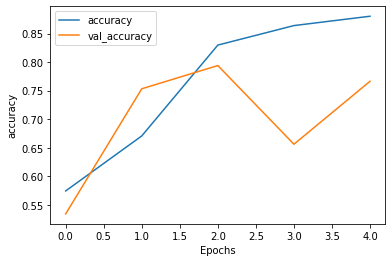

In [0]:
plot_graphs(history, 'accuracy')

In [0]:
plot_graphs(history, 'loss')

#### BERT TfHub

Creating the model for text classification:

The BERT layer takes 3 input arguments:

    1. input_word_ids: sequence of word tokens
    2. input_mask: masking the paddings
    3. segment_ids: used to identify either of the input sentences

The BERT output consists of 

    1. pooled_output, a condensed sequence representation. And
    2. sequence_output, the entire encoding of the input.

We take the sequence output and pass it to a single-unit dense layer for classification.

BERT is pre-trained on a large text corpus and it has generated its own vocabulary. We use its own tokenizer to tokenize our sentences.

Note: Sentences always start with '[CLS]' token and it's embedding is used as a sentence-level representation(sequence_output[:, 0, :]).

In [0]:
!pip install bert-for-tf2
!pip install sentencepiece

import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer

     |████████████████████████████████| 40kB 2.3MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.4-cp36-none-any.whl size=29944 sha256=3d1a3d4b9f91130f34a7d6f52e9c28cafe5f29051469a93b5c0cca24632464ec
  Stored in directory: /root/.cache/pip/wheels/d1/14/6d/b36f1618f939480ce5baa48e4d918ea00669f1cbbec4419514
  Created wheel for py-params: filename=py_params-0.8.2-cp36-none-any.whl size=4635 sha256=605662a06da2198fe7385aa2518318bdd6d3e47d18994365787b2cfc8dda26b0
  Stored in directory: /root/.cache/pip/wheels/83/3a/9c/baf35d6f17f0c2c6b61bf8ac3ab9fc12df0e41432ccaeecacb
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=9e117aff903d51fbdda7b4035902d9c57c64fbb6b434f82f737f1786c03f1367
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.0MB 2.6MB/s 


In [0]:
def get_bert_layer_tokenizer():
    # Creating the bert layer
    # module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
    module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
    bert_layer = hub.KerasLayer(module_url, trainable=True)

    # Instantiating BERT Tokenizer
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = FullTokenizer(vocab_file, do_lower_case)
    return bert_layer, tokenizer

def get_tokens(tweet, tokenizer):
    tokens = tokenizer.tokenize(tweet)
    return ["[CLS]"] + tokens + ["[SEP]"]

def get_ids(tokens, tokenizer, max_seq_length=160):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length")

    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length - len(token_ids))
    
    return input_ids

def get_masks(tokens, max_seq_length=160):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length")

    return [1] * len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length=160):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length")

    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == '[SEP]':
            current_segment_id = 1

    return segments + [0] * (max_seq_length - len(tokens))

def bert_encode(X, tokenizer):
    token_ids = []
    token_masks= []
    token_segments = []

    for text in X:
        tokens = get_tokens(text, tokenizer)

        token_id = get_ids(tokens, tokenizer)
        token_mask = get_masks(tokens)
        token_segment = get_segments(tokens)

        token_ids.append(token_id)
        token_masks.append(token_mask)
        token_segments.append(token_segment)

    return np.array(token_ids), np.array(token_masks), np.array(token_segments)

# def preprocessing_data(texts):
#     tokens = texts.map(lambda tweet: get_tokens(tweet))

#     token_ids = tokens.map(lambda tweet: np.array(get_ids(tweet)))
#     token_masks = tokens.map(lambda tweet: np.array(get_masks(tweet)))
#     token_segments = tokens.map(lambda tweet: np.array(get_segments(tweet)))

#     return np.array(token_ids), np.array(token_masks), np.array(token_segments)

In [0]:
def bert_model(bert_layer, max_seq_length = 512):
    input_word_ids = keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
    input_mask = keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
    segment_ids = keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="segment_ids")
    # bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
    #                             trainable=True)
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    '''
    x = keras.layers.Bidirectional(keras.layers.LSTM(64))(sequence_output)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1, activation='softmax')(x)
    '''
    
    kernel_size = 5
    filters = 64
    pool_size = 4
    
    x = keras.layers.Dropout(0.1)(sequence_output)
    x = keras.layers.Conv1D(filters,
                            kernel_size,
                            padding='valid',
                            activation='relu',
                            strides=1)(x)
    x = keras.layers.MaxPooling1D(pool_size=pool_size)(x)
    x = keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
    out = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    opt = keras.optimizers.Adam(lr=1e-5)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
batch_size = 16
epochs = 20

X, Y = get_training_data()
bert_layer, tokenizer = get_bert_layer_tokenizer()
X = bert_encode(X, tokenizer)

bert = bert_model(bert_layer)
bert_summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=4,
    mode='max',
    restore_best_weights=True)

history = bert.fit(X, Y, batch_size=batch_size, epochs=1, validation_split=0.15, callbacks=[early_stopping])

##### BERT Tamnun ML

In [0]:
#!pip install tamnun
from tamnun.bert import BertClassifier, BertVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

bert_tamnun = Pipeline([
                        ('bert_vec', BertVectorizer()),
                        ('bert_clf', BertClassifier(num_of_classes=2))
])

X, y = get_training_data()
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=1000, random_state=42)

bert_tamnun.fit(train_X, train_y)
preds = bert_tamnun.predict(test_X)
print(accuracy_score(test_y, preds))

Epoch 1/5:
1653/1654 batch loss: 1.046263575553894 avg loss: 0.7602737967505997
Epoch 2/5:
1653/1654 batch loss: 0.6653088331222534 avg loss: 0.7609784273383406
Epoch 3/5:
1653/1654 batch loss: 0.6995300054550171 avg loss: 0.7758783956825228
Epoch 4/5:
1653/1654 batch loss: 0.5239039659500122 avg loss: 0.7662143060056877
Epoch 5/5:
1653/1654 batch loss: 0.2842283546924591 avg loss: 0.7487616022325773
0.574


#### SuperLearner Ensemble

In [0]:
# !pip install tamnun
# from tamnun.bert import BertClassifier, BertVectorizer

!pip install bert-for-tf2
!pip install sentencepiece
import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy


class ToDense(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

def get_ensemble():
    tfidf_vectorizer = TfidfVectorizer(
        preprocessor=lambda x: x,
        tokenizer=lambda x: x,
        token_pattern=None
    )

    lr_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('lr', LogisticRegression())])
    tree_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('dt', DecisionTreeClassifier())])
    gaus_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('to_dense', ToDense()), ('gaus', GaussianNB())])
    kn_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('kn', KNeighborsClassifier())])
    svm_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('svm', SVC(gamma='scale', probability=True))])
    bag_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('bag', BaggingClassifier(n_estimators=10))])
    rf_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('rf', RandomForestClassifier(n_estimators=10))])
    et_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('et', ExtraTreesClassifier(n_estimatos=10))])
    ada_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('ada', AdaBoostClassifier(n_estimators=10))])
    gb_pipe = Pipeline([('tfidf', TfidfVectorizer()),('gb', GradientBoostingClassifier(n_estimators=100))])
    # bert_pipe = Pipeline([('bert_vec' BertVectorizer(), ('bert_clf', BertClassifier(num_classes=2)))])

    bert_layer, tokenizer = get_bert_layer_tokenizer()
    bert_model = bert_model(bert_layer)
    bert_model.summary()

    ensemble = list()
    # ensemble.append(bert_pipe)
    ensemble.append(bert_model)
    ensemble.append(lr_pipe)
    ensemble.append(tree_pipe)
    ensemble.append(gaus_pipe)
    ensemble.append(kn_pipe)
    ensemble.append(svm_pipe)
    ensemble.append(bag_pipe)
    ensemble.append(rf_pipe)
    ensemble.append(et_pipe)
    ensemble.append(ada_pipe)
    ensemble.append(gb_pipe)
    
    return ensemble

def get_meta_data(ensemble, X, y):
    kfold = KFold(n_splits=5, shuffle=True)
    meta_X, meta_y = list(), list()
    
    for train_ids, test_ids in kfold.split(X):
        yhat = list()
        
        train_X, train_y = X[train_ids], y[train_ids]
        test_X, test_y = X[test_ids], test_y[test_ids]
        
        meta_y.extend(test_y)
        
        for num, model in enumerate(ensembel):
            if num == 0:
                train_X = bert_encode(train_X)
                test_X = bert_encode(test_X)
                
                early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy', 
                    verbose=1,
                    patience=4,
                    mode='max',
                    restore_best_weights=True)
                
                model.fit(train_X, train_y, batch_size=16, epochs=10,
                          validation_split=0.25, callbacks=[early_stopping])
                preds = model.predict(test_X)
                _y = list()
                for t in preds:
                    one_prob = t[0]
                    zero_prob = 1 - one_prob
                    _y.append([zero_prob, one_prob])
                preds = np.asarray(_y)
            else:
                model.fit(train_X, train_y)
                preds = model.predict_proba(test_X)
            
            yhat.append(preds)

        meta_X.append(np.hstack(yhat))
    
    return np.vstack(meta_X), np.asarray(meta_y)

def fit_ensemble(ensemble, X, y):
    for num, model in enumerate(ensemble):
        if num == 0:
            X = bert_encode(X)
            early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy', 
                    verbose=1,
                    patience=4,
                    mode='max',
                    restore_best_weights=True)
                
            model.fit(train_X, train_y, batch_size=16, epochs=10,
                      validation_split=0.10, callbacks=[early_stopping])
        else:
            model.fit(X, y)
    
def fit_blender(meta_X, meta_y):
    blender = ExtraTreesClassifier(n_estimators=30)
    blender.fit(meta_X, meta_y)
    return blender

def ensemble_prediction(ensemble, blender, X):
    meta_X = list()
    for num, model in enumerate(ensemble):
        if num == 0:
            preds = model.predict(X)
            _y = list()
            for t in preds:
                one_prob = t[0]
                zero_prob = 1 - one_prob
                _y.append([zero_prob, one_prob])
            preds = np.asarray(_y)
        else:
            preds = model.predict_proba(X)
        meta_X.append(preds)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_x)


In [0]:
X, y = get_training_data()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=1000, random_state=42)

ensemble = get_ensemble()

meta_X, meta_y = get_meta_data(ensemble, train_X, train_y)
print('Meta data: ', meta_X.shape)

fit_ensemble(ensemble, train_X, train_y)

blender = fit_blender(meta_X, meta_y)

test_preds = ensemble_prediction(ensemble, blender, test_X)

print(accuracy_score(train_y, test_preds))

In [0]:
X, y = get_training_data()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=1000, random_state=42)

estimators = [
              ('rf', make_pipeline(TfidfVectorizer(), RandomForestClassifier())),
              ('bg', make_pipeline(TfidfVectorizer(), BaggingClassifier())),
              ('gb', make_pipeline(TfidfVectorizer(), GradientBoostingClassifier())),
              ('ada', make_pipeline(TfidfVectorizer(), AdaBoostClassifier())),
              ('et', make_pipeline(TfidfVectorizer(), ExtraTreesClassifier())),
              ('bert', make_pipeline(BertVectorizer(), BertClassifier(num_of_classes=2)))
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(train_X, train_y).score(test_X, test_y)